# 1.) Import an asset price from Yahoo Finance

In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly



```
# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
```



In [24]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [25]:
returns_series = stock_data["Adj Close"].pct_change().dropna()
df = pd.DataFrame({
    'target':np.where(returns_series>0,1,0),
    'lag1': returns_series.shift(1),
    'lag2': returns_series.shift(2),
    'lag3': returns_series.shift(3),
    'lag4': returns_series.shift(4),
    'lag5': returns_series.shift(5),
}).dropna()

training_data_len = int(len(scaled_data) * 0.8)
train_data = df.iloc[0:training_data_len, :]
test_data = df.iloc[training_data_len+1:, :]

x_train = np.array(train_data.drop(columns = 'target'))
y_train = np.array(train_data['target'])

x_test = np.array(test_data.drop(columns = 'target'))
y_test = np.array(test_data['target'])

In [26]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
6452/6452 [==============================] - 38s 5ms/step - loss: 0.2413 - accuracy: 0.5984
Epoch 2/5
6452/6452 [==============================] - 35s 5ms/step - loss: 0.2395 - accuracy: 0.6011
Epoch 3/5
6452/6452 [==============================] - 36s 6ms/step - loss: 0.2384 - accuracy: 0.6043
Epoch 4/5
6452/6452 [==============================] - 35s 5ms/step - loss: 0.2379 - accuracy: 0.6040
Epoch 5/5
6452/6452 [==============================] - 35s 5ms/step - loss: 0.2377 - accuracy: 0.6043


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart



```
test_data = scaled_data[training_data_len - input_size:, :]

x_test = [] 
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
```



In [28]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

51/51 [==============================] - 0s 4ms/step


In [29]:
train_rmse = np.sqrt(np.mean((train_pred - y_train)**2))
test_rmse = np.sqrt(np.mean((test_pred - y_test)**2))
score = model.evaluate(x_train, y_train, batch_size=1)
in_accuracy = score[1]
train_data['predictions_rw'] = train_data['target'].shift(1).dropna()
rw_accuracy_train = (train_data['predictions_rw'] == train_data['target']).sum()/len(train_data)
print('In sample accuracy:', in_accuracy)
print('In sample random walk accuracy:', rw_accuracy_train)

6452/6452 [==============================] - 17s 2ms/step - loss: 0.2361 - accuracy: 0.6073
In sample accuracy: 0.6072535514831543
In sample random walk accuracy: 0.5382827030378178


<ipython-input-29-e848f73f1e1a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predictions_rw'] = train_data['target'].shift(1).dropna()


In [30]:
score = model.evaluate(x_test, y_test, batch_size=1)
out_accuracy = score[1]
test_data['predictions_rw'] = test_data['target'].shift(1).dropna()
rw_accuracy = (test_data['predictions_rw'] == test_data['target']).sum()/len(test_data)
print('Out of sample accuracy:', out_accuracy)
print('Out of sample random walk accuracy:', rw_accuracy)

1607/1607 [==============================] - 4s 2ms/step - loss: 0.2362 - accuracy: 0.6092
Out of sample accuracy: 0.6092097163200378
Out of sample random walk accuracy: 0.5183571873055383


<ipython-input-30-ec2c966679f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions_rw'] = test_data['target'].shift(1).dropna()


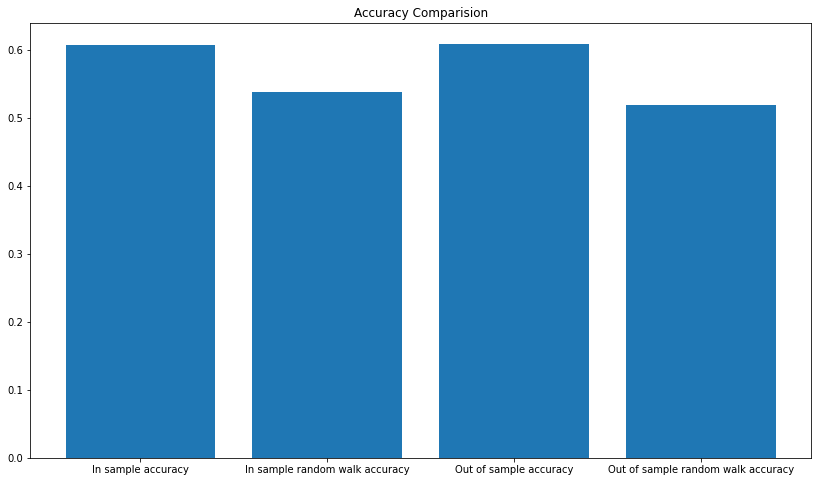

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,8))
plt.bar(x = ['In sample accuracy','In sample random walk accuracy', 'Out of sample accuracy', 'Out of sample random walk accuracy'],height = [in_accuracy, rw_accuracy_train, out_accuracy, rw_accuracy])
plt.title('Accuracy Comparision')
plt.show()

# 4.) Plot in and out of sample accuracy


```
# import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
```



#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From the above results, the model predictions have higher accuracy than the random walk predictions in both in sample and out of sample test.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [36]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [37]:
# Preprocess data
scaled_data = np.array(stock_data["Adj Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

In [41]:
def resample(input_size):
    x_train = []
    y_train = []

    for i in range(input_size, len(train_data)):
       x_train.append(train_data[i-input_size:i, 0])
       y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len - input_size:, :]
    x_test = [] 
    y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
    for i in range(input_size, len(test_data)):
       x_test.append(test_data[i-input_size:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_train, y_train, x_test, y_test

model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
#param_grid = {'input_size': [5, 10, 20]}

# Wrap the Keras model in a scikit-learn compatible estimator
#x_train, y_train= resample(input_size)
#model = KerasRegressor(build_fn=create_model, verbose=0)

# Perform the grid search over the hyperparameters
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(x_train, y_train)

# Print the results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [43]:
input_size = [5,10,20]
for i in input_size:
  x_train, y_train, x_test, y_test= resample(i)
  model.fit(x_train, y_train, batch_size=1, epochs=1)
  train_pred = model.predict(x_train)
  test_pred = model.predict(x_test)
  print(i,':   ',np.sqrt(np.mean((train_pred - y_train)**2)))
  print(i,':   ',np.sqrt(np.mean((test_pred - y_test)**2)))

51/51 [==============================] - 0s 3ms/step
5 :    0.39777460973813683
5 :    0.36609844717355244
51/51 [==============================] - 0s 4ms/step
10 :    0.39153856852027863
10 :    0.33985455305260853
51/51 [==============================] - 0s 6ms/step
20 :    0.3904996495299839
20 :    0.33994085174852917


I tried many times but I couldn't use GridSearchCV to get what I want, so I have to use for loop. For in-sample MSE, use 20 days of data perform the best, while for out-of-sample MSE, use 10 days of data is good enough.